In [1]:
import os 
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 0

In [ ]:
# cap = cv2.VideoCapture(0)
# for imgnum in range(number_images):
#     print('collecting image {}'.format(imgnum))
#     ret,frame = cap.read()
#     imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
#     cv2.imwrite(imgname,frame)
#     cv2.imshow('frame',frame)
#     time.sleep(0.5)             

#     if cv2.waitKey(1) &0xFF==ord('q'):
#         break
# cap.release()
# cv2.destroyAllWindows()

In [2]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\Anshul Rana\.labelmerc


Import TF and Deps

In [3]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

Limit GPU and Memory Growth

In [4]:
# # Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
   tf.config.experimental.set_memory_growth(gpu,True)
 

In [5]:
tf.__version__
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7056618991583231850
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1734816564
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8237462589110008010
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [25]:
len(tf.config.list_physical_devices('GPU')) > 0

True

Load Images into TF Data Pipeline

In [7]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [18]:
images.as_numpy_iterator().next()

b'data\\images\\4a35c00a-6cd1-11ee-9c4d-c577aa79cf00.jpg'

In [15]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img=tf.io.decode_jpeg(byte_img)
    return img

In [19]:
images=images.map(load_image)

In [20]:
images.as_numpy_iterator().next()

array([[[194, 187, 177],
        [192, 185, 175],
        [188, 184, 173],
        ...,
        [253, 251, 254],
        [254, 252, 255],
        [255, 253, 255]],

       [[193, 186, 176],
        [192, 185, 175],
        [188, 184, 173],
        ...,
        [254, 252, 255],
        [255, 253, 255],
        [255, 253, 255]],

       [[192, 188, 177],
        [191, 187, 176],
        [191, 187, 176],
        ...,
        [254, 252, 253],
        [253, 253, 253],
        [253, 253, 253]],

       ...,

       [[ 46,  44,  45],
        [ 44,  42,  43],
        [ 41,  39,  40],
        ...,
        [ 97,  91,  91],
        [ 99,  93,  93],
        [100,  94,  94]],

       [[ 48,  48,  50],
        [ 41,  41,  43],
        [ 40,  40,  42],
        ...,
        [100,  94,  94],
        [ 98,  92,  92],
        [ 97,  91,  91]],

       [[ 43,  43,  45],
        [ 47,  47,  49],
        [ 44,  44,  46],
        ...,
        [100,  94,  94],
        [100,  94,  94],
        [ 99,  93,  93]]

In [ ]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

View Raw Images with Matplotlib

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()

In [44]:
plot_images = image_generator.next()

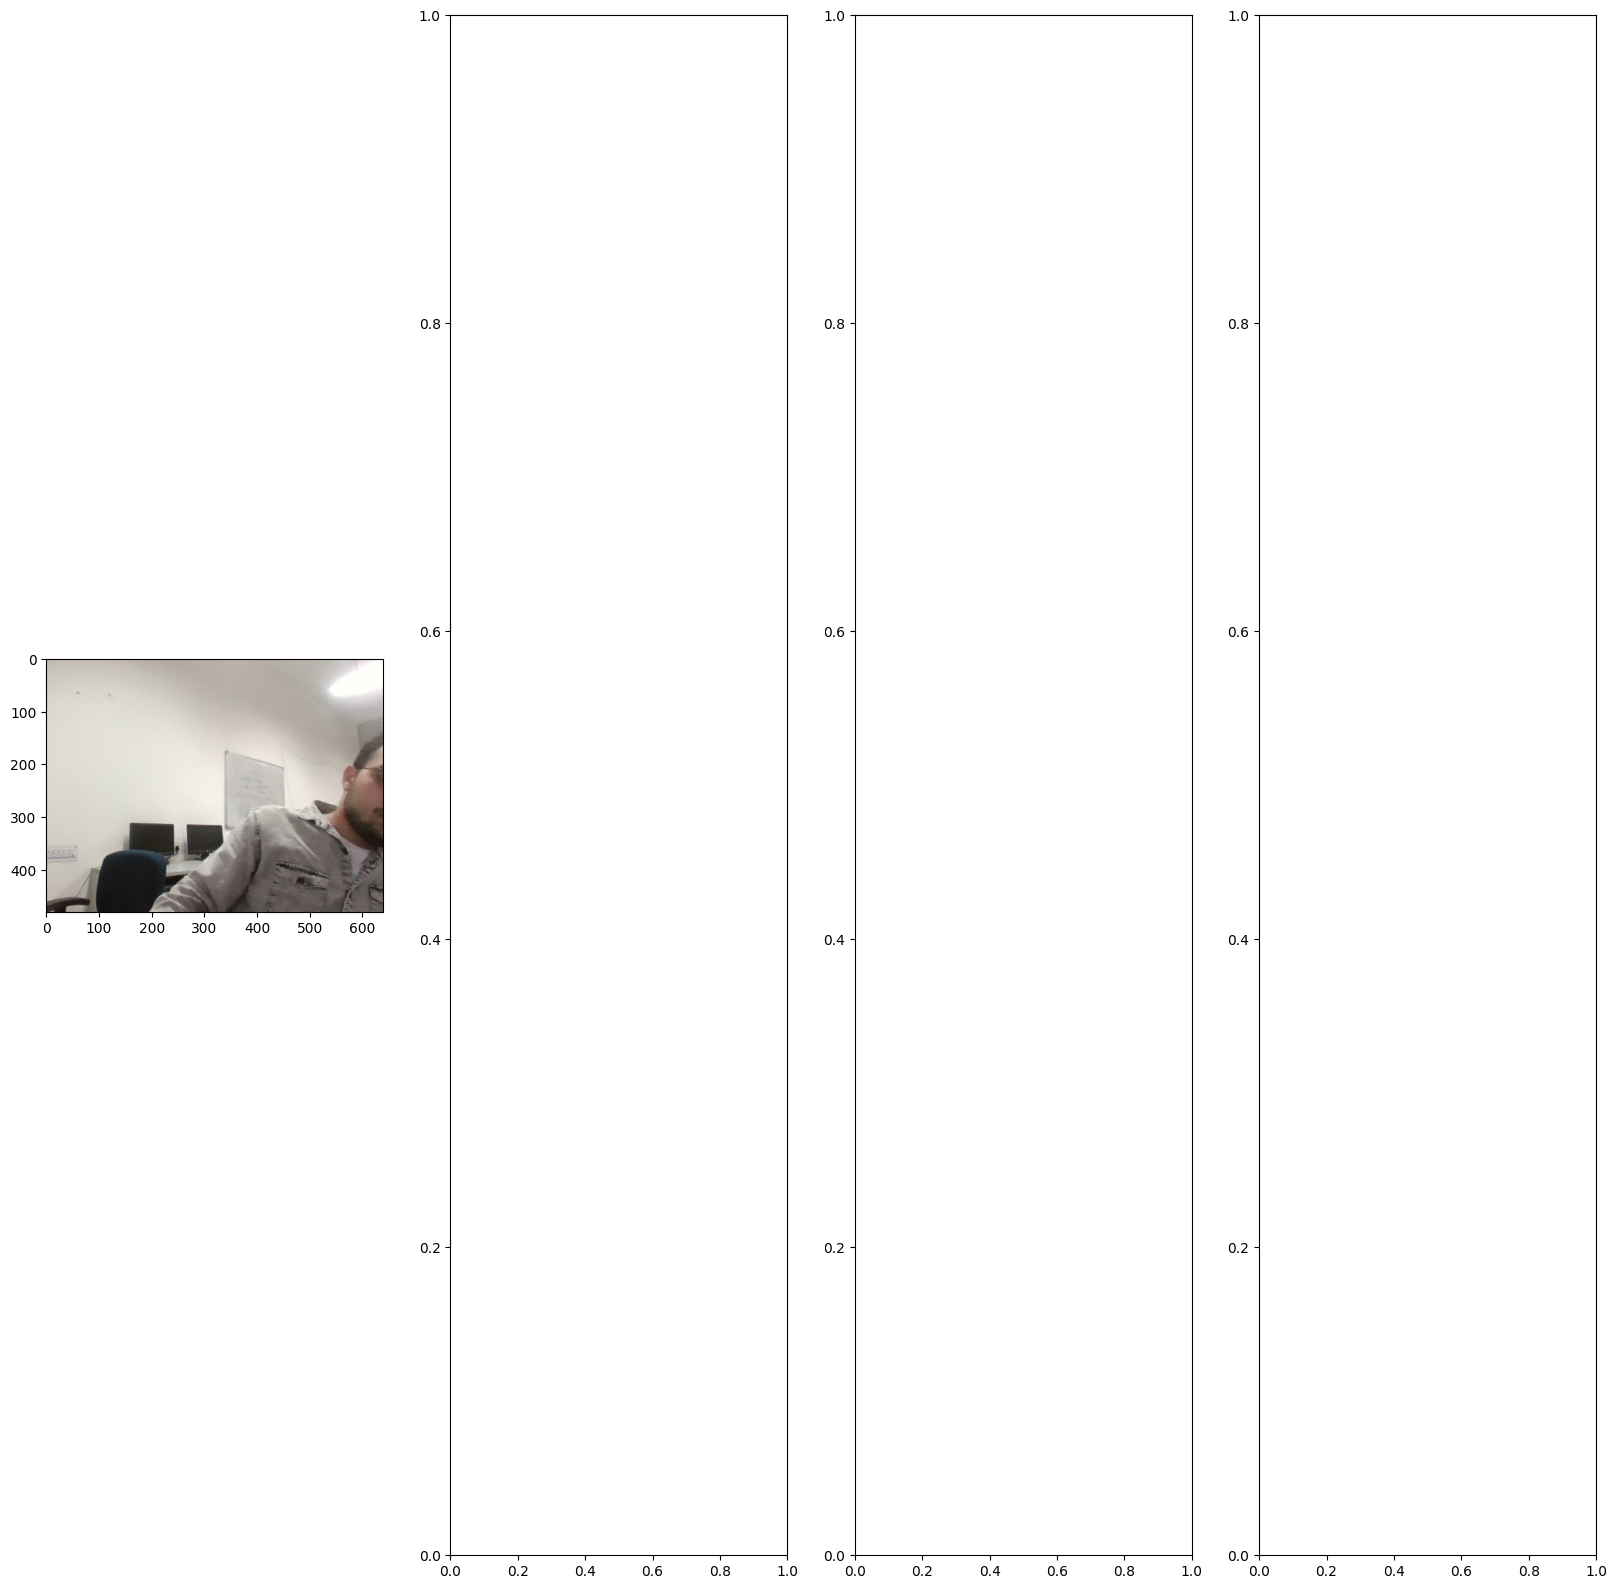

In [45]:
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()       

Partition Unaugmented Data

In [46]:
# Total Images =101
# train=71
# test = 15
# validation = 15
# we have manually seperated images to test train and validation images directory
# Now we will 

In [5]:
for folder in ['train','test', 'val']:
    for file in os.listdir(os.path.join('data',folder,'images')):
        fileName = file.split('.')[0]+'.json'
        existingFilepath= os.path.join('data','labels',fileName)
        if os.path.exists(existingFilepath):
            newFilepath=os.path.join('data',folder,'labels',fileName)
            os.replace(existingFilepath,newFilepath)

Apply Image Augmentation on Images and Labels using Albumentations

In [ ]:
import albumentations as alb

In [ ]:
augmentor = alb.Compose([alb.RandomCrop(width=450,height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                         bbox_params=alb.BboxParams(format='albumentations',label_fields=['class_labels'])
                          )

Load a test Image and Annotation with OpenCV and JSON

In [12]:
import cv2
import os
img = cv2.imread(os.path.join('data','train','images','4a35c00a-6cd1-11ee-9c4d-c577aa79cf00.jpg'))
img.shape

(480, 640, 3)

In [8]:
with open(os.path.join('data','train','labels','4a35c00a-6cd1-11ee-9c4d-c577aa79cf00.json'),'r') as f:
    label = json.load(f)    

label['shapes'][0]['points']

[[557.958115183246, 132.14659685863876], [639.0, 354.3851675932426]]

Extract Coordinates and Rescale to Match Image Image Resolution

In [ ]:
coords = [0,0,0,0]
coords[0]= label['shapes'][0]['points'][0][0]
coords[1]= label['shapes'][0]['points'][0][1]
coords[2]= label['shapes'][0]['points'][1][0]
coords[3]= label['shapes'][0]['points'][1][1]

In [ ]:
coords

[557.958115183246, 132.14659685863876, 639.0, 354.3851675932426]

In [ ]:
coords = list(np.divide(coords,[640,480,640,480]))

In [ ]:
coords

[0.871809554973822, 0.2753054101221641, 0.9984375, 0.7383024324859221]

Apply Augmentations and View Results

In [ ]:
augmented =  augmentor(image=img, bboxes = [coords], class_labels=['face'])

In [ ]:
augmented['bboxes']
# plt.imshow(augmented['image'])

[(0.8310180337405467, 0.2714368819080861, 1.0, 0.765300372429428)]

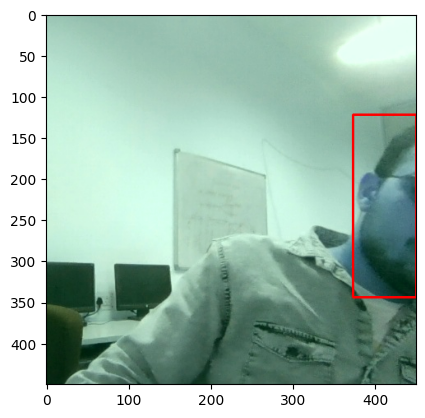

In [ ]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2],[450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:],[450,450]).astype(int)),
              (255,0,0),2)
plt.imshow(augmented['image'])

BUILD AND RUN AUGMENTATION PIPELINE

In [ ]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data',partition,'images')):
        img=cv2.imread(os.path.join('data',partition,'images',image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data',partition,'labels',f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path,'r') as f:
                label = json.load(f)

            coords[0]= label['shapes'][0]['points'][0][0]
            coords[1]= label['shapes'][0]['points'][0][1]
            coords[2]= label['shapes'][0]['points'][1][0]
            coords[3]= label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords,[640,480,640,480]))

        try:
            for x in range(60):
                augmented =  augmentor(image=img, bboxes = [coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data',partition,'images',f'{image.split(".")[0]}.{x}.jpg'),augmented['image']) 
                annotation = {}
                annotation['image']=image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] =[0,0,0,0]
                        annotation['class']= 0
                    else:
                        annotation['bbox']=augmented['bboxes'][0]
                        annotation['class'] =1
                else:
                    annotation['bbox']=[0,0,0,0]
                    annotation['class']=0    

                with open(os.path.join('aug_data',partition,'labels',f'{image.split(".")[0]}.{x}.json'),'w') as f:
                    json.dump(annotation,f)
        except Exception as e:
            print(e) 
                  

Load Augmented Images to Tensorflow Dataset

In [16]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg',shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x,(120,120)))
train_images = train_images.map(lambda x: x/255)

In [17]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg',shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x,(120,120)))
test_images = test_images.map(lambda x: x/255)


In [18]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg',shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x,(120,120)))
val_images = val_images.map(lambda x: x/255)

In [18]:
train_images.as_numpy_iterator().next()

array([[[0.68921566, 0.67107844, 0.6431373 ],
        [0.69552696, 0.6719363 , 0.639277  ],
        [0.7066789 , 0.67922795, 0.64001226],
        ...,
        [0.7254902 , 0.7137255 , 0.6813725 ],
        [0.720098  , 0.7040441 , 0.67873776],
        [0.72248775, 0.70778185, 0.6768995 ]],

       [[0.68443626, 0.6670956 , 0.63884807],
        [0.6916054 , 0.6759191 , 0.640625  ],
        [0.69050246, 0.6748162 , 0.6395221 ],
        ...,
        [0.71770835, 0.71770835, 0.6863358 ],
        [0.7214461 , 0.7098652 , 0.68235296],
        [0.72273284, 0.71096814, 0.6786152 ]],

       [[0.68572307, 0.67248774, 0.6371936 ],
        [0.69620097, 0.6805147 , 0.6452206 ],
        [0.69123775, 0.6755515 , 0.64025736],
        ...,
        [0.7142157 , 0.7142157 , 0.68284315],
        [0.70637256, 0.70637256, 0.675     ],
        [0.71568626, 0.7143995 , 0.68688726]],

       ...,

       [[0.18468137, 0.16213235, 0.18958333],
        [0.17965686, 0.15318628, 0.18063726],
        [0.32230392, 0

Prepare Labels

In [10]:
def load_labels(label_path):
    with open(label_path.numpy(),'r',encoding = 'utf-8') as f:
        label= json.load(f)

    return [label['class']] , label['bbox']       

Load Labels to Tensorflow Dataset

In [19]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json',shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))
train_labels

<MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.uint8, name=None), TensorSpec(shape=<unknown>, dtype=tf.float16, name=None))>

In [20]:

test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json',shuffle=False)
test_labels =test_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [21]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json',shuffle=False)
val_labels =val_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [22]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.529 , 0.2563, 0.8477, 0.7007], dtype=float16))

Combine Lable and Image Samples

In [23]:
len(train_images),len(train_labels),len(test_images),len(test_labels),len(val_images),len(val_labels)

(4260, 4260, 900, 900, 840, 840)

Create a final Dataset of Images and Labels

In [25]:
train = tf.data.Dataset.zip((train_images,train_labels))
train = train.shuffle(5500)
train = train.batch(8)
train = train.prefetch(4)

In [26]:
test = tf.data.Dataset.zip((test_images,test_labels))
test = test.shuffle(1500)
test = test.batch(8)
test = test.prefetch(4)

In [27]:
val = tf.data.Dataset.zip((val_images,val_labels))
val = val.shuffle(1100)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
train.as_numpy_iterator().next()[0] # 8 images
train.as_numpy_iterator().next()[1] # 8 labels


In [ ]:
data_samples = train.as_numpy_iterator()

In [ ]:
res = data_samples.next()

In [ ]:
fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2],[120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:],[120,120]).astype(int)),
                    (255,0,0),2)
    ax[idx].imshow(sample_image)
    

Build Deep Learning using the Functional Api

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16 


Download VGG16

In [4]:
vgg = VGG16(include_top=False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Build instace of network

In [5]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

# Classification Model
    f1 = GlobalMaxPooling2D()(vgg)  
    class1 = Dense(2048 , activation='relu')(f1)
    class2 = Dense(1,activation='sigmoid')(class1)

# Regression Model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048,activation='relu')(f2)
    regress2= Dense(4,activation='sigmoid')(regress1)    

    facetracker = Model(inputs=input_layer,outputs=[class2,regress2])
    return facetracker

Test out Neural Network

In [6]:
facetracker = build_model()

In [7]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [28]:
X,y = train.as_numpy_iterator().next()
X.shape

(8, 120, 120, 3)

In [35]:
classes , coords = facetracker.predict(X)

1/1 [==============================] - 6s 6s/step


In [ ]:
classes,coords

(array([[0.5139954 ],
        [0.4936566 ],
        [0.5375159 ],
        [0.5076446 ],
        [0.5117563 ],
        [0.4727328 ],
        [0.43098095],
        [0.44078892]], dtype=float32),
 array([[0.45786327, 0.44903457, 0.41970775, 0.61815727],
        [0.4521798 , 0.41715956, 0.4179008 , 0.58956116],
        [0.50400436, 0.34326458, 0.3995856 , 0.61292815],
        [0.45428762, 0.43568516, 0.40324146, 0.5720909 ],
        [0.4388265 , 0.42176157, 0.49351847, 0.5922725 ],
        [0.45645294, 0.4254394 , 0.43624267, 0.60970896],
        [0.45240107, 0.43978792, 0.3783064 , 0.6562279 ],
        [0.5484757 , 0.47158954, 0.39818665, 0.61544573]], dtype=float32))

Define Losses and Optimizers

In [29]:
batches_per_epoch = len(train)
lr_decay = (1./0.73 -1)/batches_per_epoch
lr_decay

0.0006939268549692872

In [30]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001,decay=lr_decay)


In [31]:
def localization_loss(y_true,y_hat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2]-y_hat[:,:2]))
    
    h_true = y_true[:,3]-y_true[:,1]
    w_true = y_true[:,2]-y_true[:,0]
    
    h_pred = y_hat[:,3]-y_hat[:,1]
    w_pred = y_hat[:,2]-y_hat[:,0]


    delta_size = tf.reduce_sum(tf.square(w_true-w_pred) +tf.square(h_true-h_pred))
    return delta_coord + delta_size

In [32]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

Test out Loss Metrics

In [36]:
localization_loss(y[1],coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.945888>

In [37]:
classloss(y[0],classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.67351025>

In [38]:
regressloss(y[1],coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.945888>

Train Neural Network

using the above knowledge and code we will now create a platform(class) for model to get trained
 

In [39]:
class FaceTracker(Model):
    def __init__(self,eyetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker
    
    def compile(self,optimizer,classloss,localizationloss,**kwargs):
        super().compile(**kwargs)
        self.opt = optimizer
        self.closs = classloss
        self.lloss = localizationloss
 
    def train_step(self,batch, **kwargs):

        X,y = batch

        with tf.GradientTape() as tape:
            classes,coords = self.model(X,training=True)

            batch_classloss = self.closs(y[0],classes)
            batch_localizationloss = self.lloss(tf.cast(y[1],tf.float32),coords)

            total_loss = 0.5*batch_classloss + batch_localizationloss   
             
            grad= tape.gradient(total_loss,self.model.trainable_variables)

        opt.apply_gradients(zip(grad,self.model.trainable_variables))

        return {"total_loss":total_loss,"class_loss":batch_classloss,"localization_loss":batch_localizationloss}     

    def test_step(self,batch, **kwargs):

        X,y = batch

        classes,coords = self.model(X,training=False)

        batch_classloss = self.closs(y[0],classes)
        batch_localizationloss = self.lloss(tf.cast(y[1],tf.float32),coords)

        total_loss = 0.5*batch_classloss + batch_localizationloss   

        return {"total_loss":total_loss,"class_loss":batch_classloss,"localization_loss":batch_localizationloss} 
          
    def call(self,X, **kwargs):
        return self.model(X, **kwargs)

In [40]:
model = FaceTracker(facetracker)

In [41]:
model.compile(opt,classloss,regressloss)

Train

In [42]:
logdir = "logs"

In [43]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

TRAINING THE MODEL

In [44]:
hist = model.fit(train,epochs = 30,validation_data=val,callbacks=[tensorboard_callback])


Epoch 1/30


533/533 [==============================] - 102s 163ms/step - total_loss: 0.2503 - class_loss: 0.0530 - localization_loss: 0.2238 - val_total_loss: 0.0772 - val_class_loss: 0.0022 - val_localization_loss: 0.0761
Epoch 2/30
533/533 [==============================] - 99s 159ms/step - total_loss: 0.0436 - class_loss: 0.0053 - localization_loss: 0.0410 - val_total_loss: 0.0171 - val_class_loss: 5.7221e-06 - val_localization_loss: 0.0171
Epoch 3/30
533/533 [==============================] - 97s 152ms/step - total_loss: 0.0113 - class_loss: 1.4283e-04 - localization_loss: 0.0113 - val_total_loss: 0.0148 - val_class_loss: 3.0401e-04 - val_localization_loss: 0.0147
Epoch 4/30
533/533 [==============================] - 85s 145ms/step - total_loss: 0.0070 - class_loss: 5.0744e-05 - localization_loss: 0.0070 - val_total_loss: 0.0101 - val_class_loss: 2.1734e-05 - val_localization_loss: 0.0101
Epoch 5/30
533/533 [==============================] - 89s 156ms/step - total_loss: 0.0053 - class_loss: 3.

Checking the performance

In [45]:
hist.history

{'total_loss': [0.027463838458061218,
  0.005472959019243717,
  0.0029504415579140186,
  0.0018492748495191336,
  0.002531312871724367,
  0.004946617875248194,
  0.004447436425834894,
  0.002703045727685094,
  0.0006603079964406788,
  0.0011714394204318523,
  0.0018051126971840858,
  0.0016526497201994061,
  0.0013430101098492742,
  0.0004052487201988697,
  0.00035079166991636157,
  0.0014396078186109662,
  0.0009549276437610388,
  0.0006415070383809507,
  0.0006555302534252405,
  0.00048782501835376024,
  0.00021088356152176857,
  0.0014772515278309584,
  0.0007186587899923325,
  0.0007214521174319088,
  0.00032060520607046783,
  0.00019724461890291423,
  0.001069751102477312,
  0.0008033675840124488,
  0.0005511973286047578,
  0.0002682661870494485],
 'class_loss': [0.003450158052146435,
  4.768373287333816e-07,
  1.3351555026019923e-05,
  7.748653843009379e-06,
  1.084826908481773e-05,
  1.0281909453624394e-05,
  2.0296027287258767e-05,
  3.570571789168753e-05,
  9.894524737319443e-

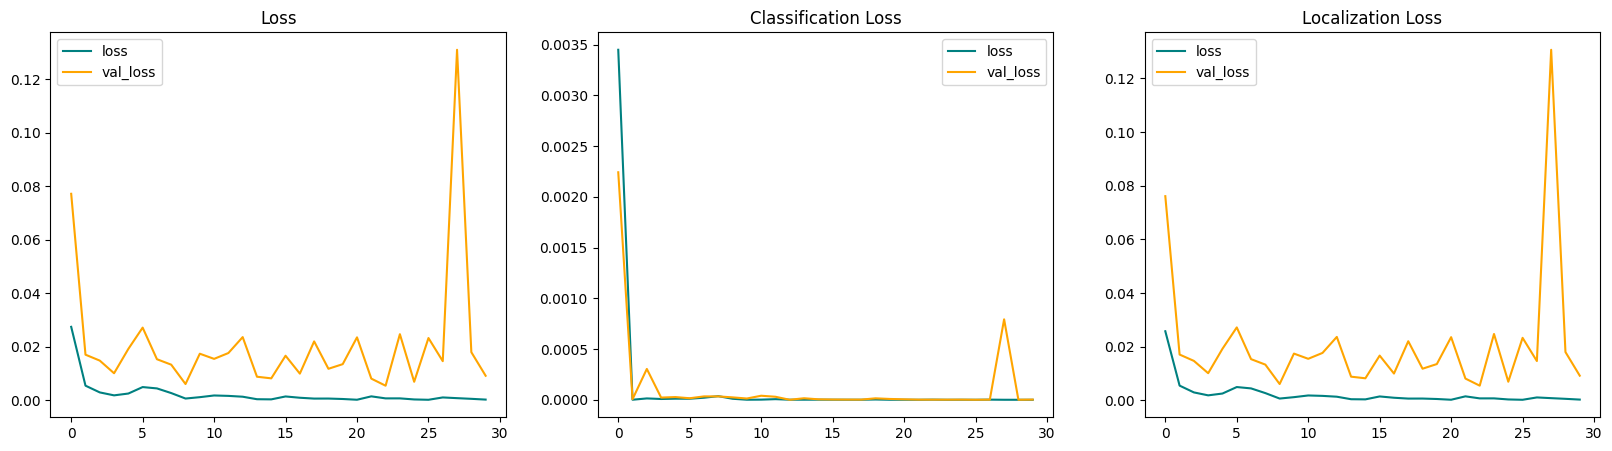

In [46]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val_loss')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val_loss')
ax[1].set_title('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['localization_loss'], color='teal', label='loss')
ax[2].plot(hist.history['val_localization_loss'], color='orange', label='val_loss')
ax[2].set_title('Localization Loss')
ax[2].legend()

plt.show()

Make Predictions

In [47]:
test_data = test.as_numpy_iterator()

In [61]:
test_sample = test_data.next()

In [62]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 56ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


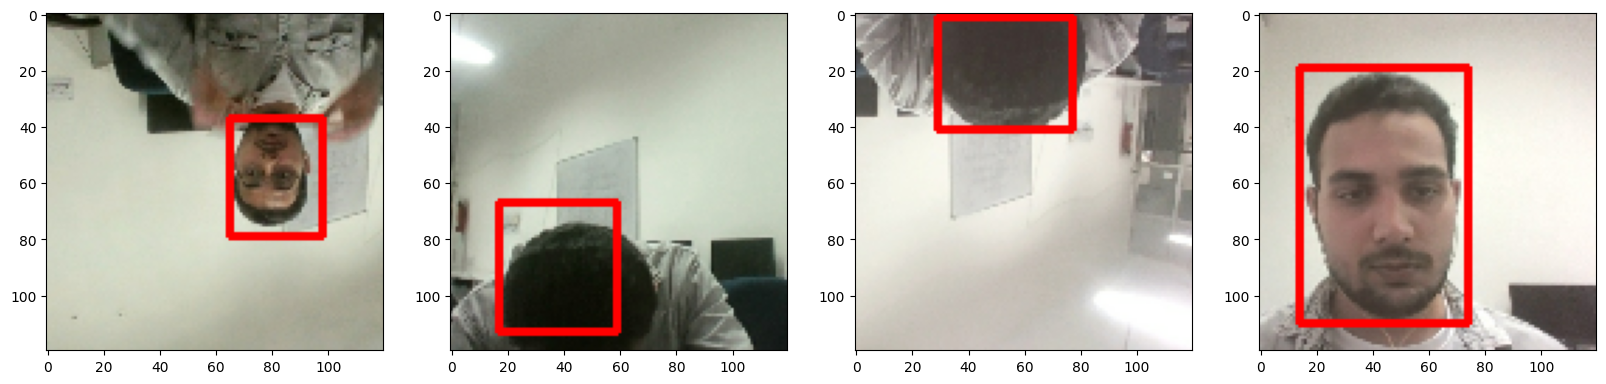

In [63]:
fig,ax = plt.subplots(ncols=4,figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
     
    if yhat[0][idx] > 0.5:
          
        cv2.rectangle(sample_image,
                    tuple(np.multiply(sample_coords[:2],[120,120]).astype(int)),
                    tuple(np.multiply(sample_coords[2:],[120,120]).astype(int)),
                        (255,0,0),2)
    ax[idx].imshow(sample_image)    

Save the Model

In [51]:
from tensorflow.keras.models import load_model

In [52]:
facetracker.save('facetracker.h5')

In [69]:
facetracker = load_model('Model/facetracker.h5')

Real Time Detection

In [70]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500,50:500,:]

    rgb = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb,(120,120))

    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]

    if yhat[0][0] > 0.5:
        cv2.rectangle(frame,
                    tuple(np.multiply(sample_coords[:2],[450,450]).astype(int)),
                    tuple(np.multiply(sample_coords[2:],[450,450]).astype(int)),
                        (255,0,0),2)
        cv2.rectangle(frame, tuple(np.add(np.multiply(sample_coords[:2],[450,450]).astype(int),
                                   [0,-30])),tuple(np.add(np.multiply(sample_coords[:2],[450,450]).astype(int),
                                    [80,0])),
                                    (255,0,0),-1)
        
        cv2.putText(frame,'Face', tuple(np.add(np.multiply(sample_coords[:2],[450,450]).astype(int),
                                    [0,-5])),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)
    cv2.imshow('EyeTrack',frame)

    if cv2.waitKey(1) &0xFF==ord('q'):
        break
cap.release()
cv2.destroyWindow("EyeTrack")
cv2.destroyAllWindows()

1/1 [==============================] - 0s 40ms/step
